In [1]:
import cv2
import numpy as np
import os
import pandas as pd
import pickle
from sklearn.neighbors import NearestNeighbors
import ast
import torch
import clip
from PIL import Image

# CLIP

In [2]:
torch.cuda.is_available()

True

In [15]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load('ViT-B/32', device=device)

In [21]:
def image_to_vector(image, model):
    # Convert image 
    image = Image.fromarray(image)
    image = transform(image).unsqueeze(0).to(device)

    # Encode using CLIP 
    with torch.no_grad():
        image_features = model.encode_image(image)

    # Normalize
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    
    return image_features.cpu().numpy()

# Create indexed DB

In [26]:
# Create pd.DataFrame for all images in path
def create_database(path, model):
    data = []
    for index, filename in enumerate(os.listdir(path)):
        img = cv2.imread(os.path.join(path, filename))
        if img is not None:
            vector = image_to_vector(img, model)
            if vector is not None:
                data.append({'index': index, 'path': os.path.join(path, filename), 'vector': vector.tolist()[0]})
    df = pd.DataFrame(data)
    return df

In [27]:
# Create the database
df = create_database('./webapp/data/voc2012/Images', model)

# Save the database to a csv file
df.to_csv('./webapp/data/database.csv', index=False)

# Fit NN model

In [17]:
# Import image db
df = pd.read_csv('./webapp/data/database.csv')

In [31]:
# Fit NearestNeighbors model
NN_model  = NearestNeighbors(metric='cosine').fit(np.array(df['vector'].apply(ast.literal_eval).tolist()))

In [32]:
# Save model
with open('./webapp/models/NN_model.pkl', 'wb') as f:
    pickle.dump(NN_model, f)

In [11]:
# Load model 
with open('./webapp/models/NN_model.pkl', 'rb') as f:
    NN_model = pickle.load(f)

# Image search realization

In [19]:
def search_image(image, model, NN_model,df, k):
    # Convert image to vector
    vector = image_to_vector(image, model)
    
    # Find the k-nearest vectors
    distances, indices = NN_model.kneighbors(vector, n_neighbors=k)
    
    # Get the paths of the k-nearest images
    paths = df.loc[indices[0], 'path']
    
    return paths.tolist()

# Demo

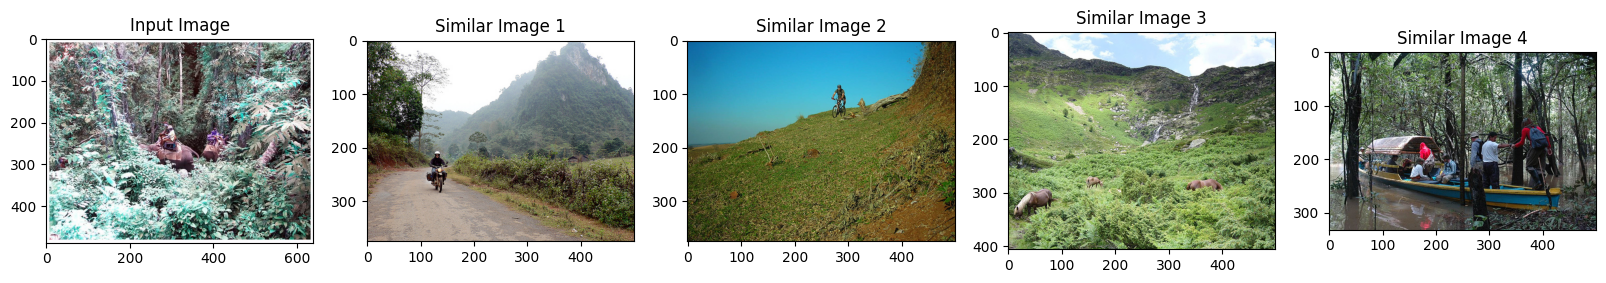

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = cv2.imread('./webapp/data/coco128_extend1024/images/000000000061.jpg')
k  = 4
# Display the input image
plt.figure(figsize=(20, 10))
plt.subplot(1, k+1, 1)
plt.imshow(image)
plt.title('Input Image')

# Search for similar images
similar_images = search_image(image, model, NN_model, df, k)

# Display the similar images
for i, path in enumerate(similar_images, 2):
    img = mpimg.imread(path)
    plt.subplot(1, k+1, i)
    plt.imshow(img)
    plt.title(f'Similar Image {i-1}')

plt.show()